### Import packages

In [1]:
import time
import tensorflow as tf
import cv2 as cv
import numpy as np
import os
import random
from matplotlib import pyplot as plt
import scipy
from scipy import signal
from scipy import ndimage
import math
import skimage.morphology
from skimage.morphology import convex_hull_image, erosion
from skimage.morphology import square
from skimage.filters import threshold_otsu, threshold_niblack, threshold_sauvola
from sklearn.metrics import roc_curve, roc_auc_score
plt.style.use('seaborn')

# Classes for data processing

### ROI, Orientation Alignment and Cropping

In [13]:
class OrientationCrop:
    
    def __init__(self):
        pass
    
    def findAngle(self, img, display=False):
        '''Finds angle/orientation of finger image'''
        
        # Grayscale
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        
        # Threshold
        _, thresh = cv.threshold(gray, 100, 255, cv.THRESH_BINARY)
        h, w = img.shape[0], img.shape[1]
        
        # Contours - Find the real contour
        contours, hierarchy = cv.findContours(thresh, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
        blank = np.zeros((h,w,3), dtype = 'uint8')         # Fow displaying purposes only
        cv.drawContours(blank, contours, -1, (0,0,255), 4) # Fow displaying purposes only
        c=[]
        for i, cnt in enumerate(contours):
            c.append(cv.contourArea(cnt))
        ind = c.index(max(c))
        cnt = contours[ind]
        
        # Fit Ellipse to get orientation
        ellipse = cv.fitEllipse(cnt)
        (x,y),(MA,ma),angle = cv.fitEllipse(cnt)
        x1, y1 = x, y                                # Fow displaying purposes only
        x2 = x1+500*math.cos((angle-90)*3.1415/180.) # Fow displaying purposes only
        y2 = y1+500*math.sin((angle-90)*3.1415/180.) # Fow displaying purposes only
        
        
        if display:
            # Show images of all steps
            cv.namedWindow('Original', cv.WINDOW_NORMAL)
            cv.imshow('Original', img)

            cv.namedWindow('Step 1: Grayscale', cv.WINDOW_NORMAL)
            cv.imshow('Step 1: Grayscale', gray)

            cv.namedWindow('Step 2: Thresholded', cv.WINDOW_NORMAL)
            cv.imshow('Step 2: Thresholded', thresh)


            cv.namedWindow('Step 3: Contour', cv.WINDOW_NORMAL)
            cv.imshow('Step 3: Contour', blank)
            thresh2 = np.zeros(img.shape)
            thresh2[:,:,0], thresh2[:,:,1], thresh2[:,:,2] = thresh.copy(), thresh.copy(), thresh.copy()
            cv.arrowedLine(thresh2,(int(x1),int(y1)),(int(x2),int(y2)),(255,0,0),8)
            cv.namedWindow('Step 4: Orientation', cv.WINDOW_NORMAL)
            cv.imshow('Step 4: Orientation', thresh2)
        
        return angle
    
    def rotate(self, img, angle, rotPoint=None, display=False):
        '''Returns the original image but rotated in the right direction'''
        
        (h,w) = img.shape[:2]
        
        if rotPoint==None:
            rotPoint = (w//2,h//2)
            
        rotMat = cv.getRotationMatrix2D(rotPoint, angle, 1.0)
        dimensions = (w,h)
        
        rotated = cv.warpAffine(img, rotMat, dimensions)
        
        if display:
            # display rotated image
            cv.namedWindow('Step 5: Rotation', cv.WINDOW_NORMAL)
            cv.imshow('Step 5: Rotation', rotated)
        
        return rotated
    
    def crop(self, rotated, display=False):
        '''
        Finds the center of the fingerprint and returns a crop of the original image
        to be passed to the next stage of preprocessing. First part is same as
        findAngle method because the contours are needed again for the new image.
        '''
        
        # Grayscale
        gray = cv.cvtColor(rotated, cv.COLOR_BGR2GRAY)
        
        # Threshold
        _, thresh = cv.threshold(gray, 100, 255, cv.THRESH_BINARY)
        h, w = rotated.shape[0], rotated.shape[1]
        
        # Contours
        contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
        blank = np.zeros((h,w,3), dtype = 'uint8')
        cv.drawContours(blank, contours, -1, (0,0,255), 3)
        # Find the real contour
        c=[]
        for i, cnt in enumerate(contours):
            c.append(cv.contourArea(cnt))
        ind = c.index(max(c))
        cnt = contours[ind]

        # Fit Rectangle/Get center
        x,y,w,h = cv.boundingRect(cnt)
        
        # Crop
        cropped = rotated[y:y+h, x:x+w, :]
        
        if display:
            # display cropped image
            cv.namedWindow('Step 6: Crop', cv.WINDOW_NORMAL)
            cv.imshow('Step 6: Crop', cropped)
            cv.waitKey(0)
        return cropped
    
    def process(self, img):
        '''Runs all the methods and returns final cropped BGR image'''
        angle = self.findAngle(img)
        rotated = self.rotate(img, angle)
        cropped = self.crop(rotated)
        return cropped
    
    # This method will be to plot all the steps of the process
    def process_and_display(self, img):
        '''Runs all the methods BUT displays the result of each step'''
        angle = self.findAngle(img, display=True)
        rotated = self.rotate(img, angle, display=True)
        cropped = self.crop(rotated, display=True)

### Fingerprint Enhancement

In [3]:
class FingerprintImageEnhancer(object):
    def __init__(self):
        self.ridge_segment_blksze = 16
        self.ridge_segment_thresh = 0.1
        self.gradient_sigma = 1
        self.block_sigma = 7
        self.orient_smooth_sigma = 7
        self.ridge_freq_blksze = 38
        self.ridge_freq_windsze = 5
        self.min_wave_length = 5
        self.max_wave_length = 15
        self.kx = 0.65
        self.ky = 0.65
        self.angleInc = 3
        self.ridge_filter_thresh = -3


        self._mask = []
        self._normim = []
        self._orientim = []
        self._mean_freq = []
        self._median_freq = []
        self._freq = []
        self._freqim = []
        self._binim = []

    def __normalise(self, img, mean, std):
        if(np.std(img) == 0):
            raise ValueError("Image standard deviation is 0. Please review image again")
        normed = (img - np.mean(img)) / (np.std(img))
        return (normed)

    def __ridge_segment(self, img):
        # RIDGESEGMENT - Normalises fingerprint image and segments ridge region
        #
        # Function identifies ridge regions of a fingerprint image and returns a
        # mask identifying this region.  It also normalises the intesity values of
        # the image so that the ridge regions have zero mean, unit standard
        # deviation.
        #
        # This function breaks the image up into blocks of size blksze x blksze and
        # evaluates the standard deviation in each region.  If the standard
        # deviation is above the threshold it is deemed part of the fingerprint.
        # Note that the image is normalised to have zero mean, unit standard
        # deviation prior to performing this process so that the threshold you
        # specify is relative to a unit standard deviation.
        #
        # Usage:   [normim, mask, maskind] = ridgesegment(im, blksze, thresh)
        #
        # Arguments:   im     - Fingerprint image to be segmented.
        #              blksze - Block size over which the the standard
        #                       deviation is determined (try a value of 16).
        #              thresh - Threshold of standard deviation to decide if a
        #                       block is a ridge region (Try a value 0.1 - 0.2)
        #
        # Ouput:     normim - Image where the ridge regions are renormalised to
        #                       have zero mean, unit standard deviation.
        #              mask   - Mask indicating ridge-like regions of the image,
        #                       0 for non ridge regions, 1 for ridge regions.
        #              maskind - Vector of indices of locations within the mask.
        #
        # Suggested values for a 500dpi fingerprint image:
        #
        #   [normim, mask, maskind] = ridgesegment(im, 16, 0.1)
        #
        # See also: RIDGEORIENT, RIDGEFREQ, RIDGEFILTER

        ### REFERENCES

        # Peter Kovesi
        # School of Computer Science & Software Engineering
        # The University of Western Australia
        # pk at csse uwa edu au
        # http://www.csse.uwa.edu.au/~pk
        rows, cols = img.shape
        im = self.__normalise(img, 0, 1)  # normalise to get zero mean and unit standard deviation

        new_rows = int(self.ridge_segment_blksze * np.ceil((float(rows)) / (float(self.ridge_segment_blksze))))
        new_cols = int(self.ridge_segment_blksze * np.ceil((float(cols)) / (float(self.ridge_segment_blksze))))

        padded_img = np.zeros((new_rows, new_cols))
        stddevim = np.zeros((new_rows, new_cols))
        padded_img[0:rows][:, 0:cols] = im
        for i in range(0, new_rows, self.ridge_segment_blksze):
            for j in range(0, new_cols, self.ridge_segment_blksze):
                block = padded_img[i:i + self.ridge_segment_blksze][:, j:j + self.ridge_segment_blksze]

                stddevim[i:i + self.ridge_segment_blksze][:, j:j + self.ridge_segment_blksze] = np.std(block) * np.ones(block.shape)

        stddevim = stddevim[0:rows][:, 0:cols]
        self._mask = stddevim > self.ridge_segment_thresh
        mean_val = np.mean(im[self._mask])
        std_val = np.std(im[self._mask])
        self._normim = (im - mean_val) / (std_val)

    def __ridge_orient(self):
        # RIDGEORIENT - Estimates the local orientation of ridges in a fingerprint
        #
        # Usage:  [orientim, reliability, coherence] = ridgeorientation(im, gradientsigma,...
        #                                             blocksigma, ...
        #                                             orientsmoothsigma)
        #
        # Arguments:  im                - A normalised input image.
        #             gradientsigma     - Sigma of the derivative of Gaussian
        #                                 used to compute image gradients.
        #             blocksigma        - Sigma of the Gaussian weighting used to
        #                                 sum the gradient moments.
        #             orientsmoothsigma - Sigma of the Gaussian used to smooth
        #                                 the final orientation vector field.
        #                                 Optional: if ommitted it defaults to 0
        #
        # Output:    orientim          - The orientation image in radians.
        #                                 Orientation values are +ve clockwise
        #                                 and give the direction *along* the
        #                                 ridges.
        #             reliability       - Measure of the reliability of the
        #                                 orientation measure.  This is a value
        #                                 between 0 and 1. I think a value above
        #                                 about 0.5 can be considered 'reliable'.
        #                                 reliability = 1 - Imin./(Imax+.001);
        #             coherence         - A measure of the degree to which the local
        #                                 area is oriented.
        #                                 coherence = ((Imax-Imin)./(Imax+Imin)).^2;
        #
        # With a fingerprint image at a 'standard' resolution of 500dpi suggested
        # parameter values might be:
        #
        #    [orientim, reliability] = ridgeorient(im, 1, 3, 3);
        #
        # See also: RIDGESEGMENT, RIDGEFREQ, RIDGEFILTER

        ### REFERENCES

        # May 2003      Original version by Raymond Thai,
        # January 2005  Reworked by Peter Kovesi
        # October 2011  Added coherence computation and orientsmoothsigma made optional
        #
        # School of Computer Science & Software Engineering
        # The University of Western Australia
        # pk at csse uwa edu au
        # http://www.csse.uwa.edu.au/~pk

        rows,cols = self._normim.shape
        #Calculate image gradients.
        sze = np.fix(6*self.gradient_sigma)
        if np.remainder(sze,2) == 0:
            sze = sze+1

        gauss = cv.getGaussianKernel(int(sze),self.gradient_sigma)
        f = gauss * gauss.T

        fy,fx = np.gradient(f)                               #Gradient of Gaussian

        Gx = signal.convolve2d(self._normim, fx, mode='same')
        Gy = signal.convolve2d(self._normim, fy, mode='same')

        Gxx = np.power(Gx,2)
        Gyy = np.power(Gy,2)
        Gxy = Gx*Gy

        #Now smooth the covariance data to perform a weighted summation of the data.
        sze = np.fix(6*self.block_sigma)

        gauss = cv.getGaussianKernel(int(sze), self.block_sigma)
        f = gauss * gauss.T

        Gxx = ndimage.convolve(Gxx,f)
        Gyy = ndimage.convolve(Gyy,f)
        Gxy = 2*ndimage.convolve(Gxy,f)

        # Analytic solution of principal direction
        denom = np.sqrt(np.power(Gxy,2) + np.power((Gxx - Gyy),2)) + np.finfo(float).eps

        sin2theta = Gxy/denom                   # Sine and cosine of doubled angles
        cos2theta = (Gxx-Gyy)/denom


        if self.orient_smooth_sigma:
            sze = np.fix(6*self.orient_smooth_sigma)
            if np.remainder(sze,2) == 0:
                sze = sze+1
            gauss = cv.getGaussianKernel(int(sze), self.orient_smooth_sigma)
            f = gauss * gauss.T
            cos2theta = ndimage.convolve(cos2theta,f)                   # Smoothed sine and cosine of
            sin2theta = ndimage.convolve(sin2theta,f)                   # doubled angles

        self._orientim = np.pi/2 + np.arctan2(sin2theta,cos2theta)/2

    def __ridge_freq(self):
        # RIDGEFREQ - Calculates a ridge frequency image
        #
        # Function to estimate the fingerprint ridge frequency across a
        # fingerprint image. This is done by considering blocks of the image and
        # determining a ridgecount within each block by a call to FREQEST.
        #
        # Usage:
        #  [freqim, medianfreq] =  ridgefreq(im, mask, orientim, blksze, windsze, ...
        #                                    minWaveLength, maxWaveLength)
        #
        # Arguments:
        #         im       - Image to be processed.
        #         mask     - Mask defining ridge regions (obtained from RIDGESEGMENT)
        #         orientim - Ridge orientation image (obtained from RIDGORIENT)
        #         blksze   - Size of image block to use (say 32)
        #         windsze  - Window length used to identify peaks. This should be
        #                    an odd integer, say 3 or 5.
        #         minWaveLength,  maxWaveLength - Minimum and maximum ridge
        #                     wavelengths, in pixels, considered acceptable.
        #
        # Output:
        #         freqim     - An image  the same size as im with  values set to
        #                      the estimated ridge spatial frequency within each
        #                      image block.  If a  ridge frequency cannot be
        #                      found within a block, or cannot be found within the
        #                      limits set by min and max Wavlength freqim is set
        #                      to zeros within that block.
        #         medianfreq - Median frequency value evaluated over all the
        #                      valid regions of the image.
        #
        # Suggested parameters for a 500dpi fingerprint image
        #   [freqim, medianfreq] = ridgefreq(im,orientim, 32, 5, 5, 15);
        #

        # See also: RIDGEORIENT, FREQEST, RIDGESEGMENT

        # Reference:
        # Hong, L., Wan, Y., and Jain, A. K. Fingerprint image enhancement:
        # Algorithm and performance evaluation. IEEE Transactions on Pattern
        # Analysis and Machine Intelligence 20, 8 (1998), 777 789.

        ### REFERENCES

        # Peter Kovesi
        # School of Computer Science & Software Engineering
        # The University of Western Australia
        # pk at csse uwa edu au
        # http://www.csse.uwa.edu.au/~pk

        rows, cols = self._normim.shape
        freq = np.zeros((rows, cols))

        for r in range(0, rows - self.ridge_freq_blksze, self.ridge_freq_blksze):
            for c in range(0, cols - self.ridge_freq_blksze, self.ridge_freq_blksze):
                blkim = self._normim[r:r + self.ridge_freq_blksze][:, c:c + self.ridge_freq_blksze]
                blkor = self._orientim[r:r + self.ridge_freq_blksze][:, c:c + self.ridge_freq_blksze]

                freq[r:r + self.ridge_freq_blksze][:, c:c + self.ridge_freq_blksze] = self.__frequest(blkim, blkor)

        self._freq = freq * self._mask
        freq_1d = np.reshape(self._freq, (1, rows * cols))
        ind = np.where(freq_1d > 0)

        ind = np.array(ind)
        ind = ind[1, :]

        non_zero_elems_in_freq = freq_1d[0][ind]

        self._mean_freq = np.mean(non_zero_elems_in_freq)
        self._median_freq = np.median(non_zero_elems_in_freq)  # does not work properly

        self._freq = self._mean_freq * self._mask

    def __frequest(self, blkim, blkor):
        # FREQEST - Estimate fingerprint ridge frequency within image block
        #
        # Function to estimate the fingerprint ridge frequency within a small block
        # of a fingerprint image.  This function is used by RIDGEFREQ
        #
        # Usage:
        #  freqim =  freqest(im, orientim, windsze, minWaveLength, maxWaveLength)
        #
        # Arguments:
        #         im       - Image block to be processed.
        #         orientim - Ridge orientation image of image block.
        #         windsze  - Window length used to identify peaks. This should be
        #                    an odd integer, say 3 or 5.
        #         minWaveLength,  maxWaveLength - Minimum and maximum ridge
        #                     wavelengths, in pixels, considered acceptable.
        #
        # Output:
        #         freqim    - An image block the same size as im with all values
        #                     set to the estimated ridge spatial frequency.  If a
        #                     ridge frequency cannot be found, or cannot be found
        #                     within the limits set by min and max Wavlength
        #                     freqim is set to zeros.
        #
        # Suggested parameters for a 500dpi fingerprint image
        #   freqim = freqest(im,orientim, 5, 5, 15);
        #
        # See also:  RIDGEFREQ, RIDGEORIENT, RIDGESEGMENT

        ### REFERENCES

        # Peter Kovesi
        # School of Computer Science & Software Engineering
        # The University of Western Australia
        # pk at csse uwa edu au
        # http://www.csse.uwa.edu.au/~pk

        rows, cols = np.shape(blkim)

        # Find mean orientation within the block. This is done by averaging the
        # sines and cosines of the doubled angles before reconstructing the
        # angle again.  This avoids wraparound problems at the origin.

        cosorient = np.mean(np.cos(2 * blkor))
        sinorient = np.mean(np.sin(2 * blkor))
        orient = math.atan2(sinorient, cosorient) / 2

        # Rotate the image block so that the ridges are vertical

        # ROT_mat = cv.getRotationMatrix2D((cols/2,rows/2),orient/np.pi*180 + 90,1)
        # rotim = cv.warpAffine(im,ROT_mat,(cols,rows))
        rotim = scipy.ndimage.rotate(blkim, orient / np.pi * 180 + 90, axes=(1, 0), reshape=False, order=3,
                                     mode='nearest')

        # Now crop the image so that the rotated image does not contain any
        # invalid regions.  This prevents the projection down the columns
        # from being mucked up.

        cropsze = int(np.fix(rows / np.sqrt(2)))
        offset = int(np.fix((rows - cropsze) / 2))
        rotim = rotim[offset:offset + cropsze][:, offset:offset + cropsze]

        # Sum down the columns to get a projection of the grey values down
        # the ridges.

        proj = np.sum(rotim, axis=0)
        dilation = scipy.ndimage.grey_dilation(proj, self.ridge_freq_windsze, structure=np.ones(self.ridge_freq_windsze))

        temp = np.abs(dilation - proj)

        peak_thresh = 2

        maxpts = (temp < peak_thresh) & (proj > np.mean(proj))
        maxind = np.where(maxpts)

        rows_maxind, cols_maxind = np.shape(maxind)

        # Determine the spatial frequency of the ridges by divinding the
        # distance between the 1st and last peaks by the (No of peaks-1). If no
        # peaks are detected, or the wavelength is outside the allowed bounds,
        # the frequency image is set to 0

        if (cols_maxind < 2):
            return(np.zeros(blkim.shape))
        else:
            NoOfPeaks = cols_maxind
            waveLength = (maxind[0][cols_maxind - 1] - maxind[0][0]) / (NoOfPeaks - 1)
            if waveLength >= self.min_wave_length and waveLength <= self.max_wave_length:
                return(1 / np.double(waveLength) * np.ones(blkim.shape))
            else:
                return(np.zeros(blkim.shape))

    def __ridge_filter(self):
        # RIDGEFILTER - enhances fingerprint image via oriented filters
        #
        # Function to enhance fingerprint image via oriented filters
        #
        # Usage:
        #  newim =  ridgefilter(im, orientim, freqim, kx, ky, showfilter)
        #
        # Arguments:
        #         im       - Image to be processed.
        #         orientim - Ridge orientation image, obtained from RIDGEORIENT.
        #         freqim   - Ridge frequency image, obtained from RIDGEFREQ.
        #         kx, ky   - Scale factors specifying the filter sigma relative
        #                    to the wavelength of the filter.  This is done so
        #                    that the shapes of the filters are invariant to the
        #                    scale.  kx controls the sigma in the x direction
        #                    which is along the filter, and hence controls the
        #                    bandwidth of the filter.  ky controls the sigma
        #                    across the filter and hence controls the
        #                    orientational selectivity of the filter. A value of
        #                    0.5 for both kx and ky is a good starting point.
        #         showfilter - An optional flag 0/1.  When set an image of the
        #                      largest scale filter is displayed for inspection.
        #
        # Output:
        #         newim    - The enhanced image
        #
        # See also: RIDGEORIENT, RIDGEFREQ, RIDGESEGMENT

        # Reference:
        # Hong, L., Wan, Y., and Jain, A. K. Fingerprint image enhancement:
        # Algorithm and performance evaluation. IEEE Transactions on Pattern
        # Analysis and Machine Intelligence 20, 8 (1998), 777 789.

        ### REFERENCES

        # Peter Kovesi
        # School of Computer Science & Software Engineering
        # The University of Western Australia
        # pk at csse uwa edu au
        # http://www.csse.uwa.edu.au/~pk

        im = np.double(self._normim)
        rows, cols = im.shape
        newim = np.zeros((rows, cols))

        freq_1d = np.reshape(self._freq, (1, rows * cols))
        ind = np.where(freq_1d > 0)

        ind = np.array(ind)
        ind = ind[1, :]

        # Round the array of frequencies to the nearest 0.01 to reduce the
        # number of distinct frequencies we have to deal with.

        non_zero_elems_in_freq = freq_1d[0][ind]
        non_zero_elems_in_freq = np.double(np.round((non_zero_elems_in_freq * 100))) / 100

        unfreq = np.unique(non_zero_elems_in_freq)

        # Generate filters corresponding to these distinct frequencies and
        # orientations in 'angleInc' increments.

        sigmax = 1 / unfreq[0] * self.kx
        sigmay = 1 / unfreq[0] * self.ky

        sze = int(np.round(3 * np.max([sigmax, sigmay])))

        x, y = np.meshgrid(np.linspace(-sze, sze, (2 * sze + 1)), np.linspace(-sze, sze, (2 * sze + 1)))

        reffilter = np.exp(-(((np.power(x, 2)) / (sigmax * sigmax) + (np.power(y, 2)) / (sigmay * sigmay)))) * np.cos(
            2 * np.pi * unfreq[0] * x)        # this is the original gabor filter

        filt_rows, filt_cols = reffilter.shape

        angleRange = int(180 / self.angleInc)

        gabor_filter = np.array(np.zeros((angleRange, filt_rows, filt_cols)))

        for o in range(0, angleRange):
            # Generate rotated versions of the filter.  Note orientation
            # image provides orientation *along* the ridges, hence +90
            # degrees, and imrotate requires angles +ve anticlockwise, hence
            # the minus sign.

            rot_filt = scipy.ndimage.rotate(reffilter, -(o * self.angleInc + 90), reshape=False)
            gabor_filter[o] = rot_filt

        # Find indices of matrix points greater than maxsze from the image
        # boundary

        maxsze = int(sze)

        temp = self._freq > 0
        validr, validc = np.where(temp)

        temp1 = validr > maxsze
        temp2 = validr < rows - maxsze
        temp3 = validc > maxsze
        temp4 = validc < cols - maxsze

        final_temp = temp1 & temp2 & temp3 & temp4

        finalind = np.where(final_temp)

        # Convert orientation matrix values from radians to an index value
        # that corresponds to round(degrees/angleInc)

        maxorientindex = np.round(180 / self.angleInc)
        orientindex = np.round(self._orientim / np.pi * 180 / self.angleInc)

        # do the filtering
        for i in range(0, rows):
            for j in range(0, cols):
                if (orientindex[i][j] < 1):
                    orientindex[i][j] = orientindex[i][j] + maxorientindex
                if (orientindex[i][j] > maxorientindex):
                    orientindex[i][j] = orientindex[i][j] - maxorientindex
        finalind_rows, finalind_cols = np.shape(finalind)
        sze = int(sze)
        for k in range(0, finalind_cols):
            r = validr[finalind[0][k]]
            c = validc[finalind[0][k]]

            img_block = im[r - sze:r + sze + 1][:, c - sze:c + sze + 1]

            newim[r][c] = np.sum(img_block * gabor_filter[int(orientindex[r][c]) - 1])

        self._binim = newim < self.ridge_filter_thresh

    def save_enhanced_image(self, path):
        # saves the enhanced image at the specified path
        cv.imwrite(path, (255 * self._binim))

    def enhance(self, img, resize=True): ##########################################################################
        # main function to enhance the image.
        # calls all other subroutines

        if(resize):
            rows, cols = np.shape(img)
            aspect_ratio = np.double(rows) / np.double(cols)

            new_rows = 350                      # randomly selected number
            new_cols = new_rows / aspect_ratio

            img = cv.resize(img, (int(new_cols), int(new_rows)))

        self.__ridge_segment(img)   # normalise the image and find a ROI
        self.__ridge_orient()       # compute orientation image
        self.__ridge_freq()         # compute major frequency of ridges
        self.__ridge_filter()       # filter the image using oriented gabor filter
        return(self._binim)

### Fingerprint preprocessing

The script below concerns the data from the user only - that's why it was not used when preprocessing the data from the poly Dataset.

In [14]:
# Class for preprocessing, inherits the enhancment from the other class.
class ProcessEnhance(FingerprintImageEnhancer):
    def __init__(self):
        super().__init__()
        
    def binarize(self, img):
        
        # Resize
        dim = 512
        img = cv.resize(img, (dim,dim), interpolation = cv.INTER_AREA)
        
        # Create mask
        mask = np.zeros((dim,dim))
        mask = cv.ellipse(mask, center = (int(dim/2),int(dim/2)), axes = (90*2,120*2), 
                  angle = 0, startAngle = 0, endAngle = 360, color = 255, thickness=-1)
        
        # Grayscale
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        
        # Contrast Limited Adaptive Histogram Equalization - CLAHE
        clahe = cv.createCLAHE(clipLimit=20, tileGridSize=(100,100))
        cl = clahe.apply(np.uint8(gray))
        
        # Binarization - Niblack Thresholding
        nib_thr = threshold_niblack(cl, window_size=21, k=0.1)
        nib = cl > nib_thr
        nib = np.multiply(mask/255., nib)
        nib = nib*255
        self.nib = nib
        
        return nib
    
    def process(self, img):
        '''Runs two methods, first the preprocessing above and then the code for the enhancement'''
        niblack = self.binarize(img)
        enhanced_image = self.enhance(niblack)*255.
        return enhanced_image
    
    def process_and_display(self, img):
        # Display all steps of the process
        cv.namedWindow('Original', cv.WINDOW_NORMAL)
        cv.imshow('Original', img)
        
        niblack = self.binarize(img)
        cv.namedWindow('Step 1: Binarized', cv.WINDOW_NORMAL)
        cv.imshow('Step 1: Binarized', niblack)
        
        enhanced_image = self.enhance(niblack)*255.
        cv.namedWindow('Step 2: Enhanced', cv.WINDOW_NORMAL)
        cv.imshow('Step 2: Enhanced', enhanced_image)
        cv.waitKey(0)

### Minutiae Extraction

This script will be used to extract the minutiae of a fingerprint and also display them.

In [5]:
class MinutiaeFeature(object):
    def __init__(self, locX, locY, Orientation, Type):
        self.locX = locX
        self.locY = locY
        self.Orientation = Orientation
        self.Type = Type

class FingerprintFeatureExtractor(object):
    def __init__(self):
        self._mask = []
        self._skel = []
        self.minutiaeTerm = []
        self.minutiaeBif = []
        self._spuriousMinutiaeThresh = 10

    def setSpuriousMinutiaeThresh(self, spuriousMinutiaeThresh):
        self._spuriousMinutiaeThresh = spuriousMinutiaeThresh

    def __skeletonize(self, img):
        img = np.uint8(img > 128)
        self._skel = skimage.morphology.skeletonize(img)
        self._skel = np.uint8(self._skel) * 255
        self._mask = img * 255

    def __computeAngle(self, block, minutiaeType):
        angle = []
        (blkRows, blkCols) = np.shape(block)
        CenterX, CenterY = (blkRows - 1) / 2, (blkCols - 1) / 2
        if (minutiaeType.lower() == 'termination'):
            sumVal = 0
            for i in range(blkRows):
                for j in range(blkCols):
                    if ((i == 0 or i == blkRows - 1 or j == 0 or j == blkCols - 1) and block[i][j] != 0):
                        angle.append(-math.degrees(math.atan2(i - CenterY, j - CenterX)))
                        sumVal += 1
                        if (sumVal > 1):
                            angle.append(float('nan'))
            return (angle)

        elif (minutiaeType.lower() == 'bifurcation'):
            (blkRows, blkCols) = np.shape(block)
            CenterX, CenterY = (blkRows - 1) / 2, (blkCols - 1) / 2
            angle = []
            sumVal = 0
            for i in range(blkRows):
                for j in range(blkCols):
                    if ((i == 0 or i == blkRows - 1 or j == 0 or j == blkCols - 1) and block[i][j] != 0):
                        angle.append(-math.degrees(math.atan2(i - CenterY, j - CenterX)))
                        sumVal += 1
            if (sumVal != 3):
                angle.append(float('nan'))
            return (angle)

    def __getTerminationBifurcation(self):
        self._skel = self._skel == 255
        (rows, cols) = self._skel.shape
        self.minutiaeTerm = np.zeros(self._skel.shape)
        self.minutiaeBif = np.zeros(self._skel.shape)

        for i in range(1, rows - 1):
            for j in range(1, cols - 1):
                if (self._skel[i][j] == 1):
                    block = self._skel[i - 1:i + 2, j - 1:j + 2]
                    block_val = np.sum(block)
                    if (block_val == 2):
                        self.minutiaeTerm[i, j] = 1
                    elif (block_val == 4):
                        self.minutiaeBif[i, j] = 1

        self._mask = convex_hull_image(self._mask > 0)
        self._mask = erosion(self._mask, square(5))  # Structuing element for mask erosion = square(5)
        self.minutiaeTerm = np.uint8(self._mask) * self.minutiaeTerm

    def __removeSpuriousMinutiae(self, minutiaeList, img):
        img = img * 0
        SpuriousMin = []
        numPoints = len(minutiaeList)
        D = np.zeros((numPoints, numPoints))
        for i in range(1,numPoints):
            for j in range(0, i):
                (X1,Y1) = minutiaeList[i]['centroid']
                (X2,Y2) = minutiaeList[j]['centroid']

                dist = np.sqrt((X2-X1)**2 + (Y2-Y1)**2)
                D[i][j] = dist
                if(dist < self._spuriousMinutiaeThresh):
                    SpuriousMin.append(i)
                    SpuriousMin.append(j)

        SpuriousMin = np.unique(SpuriousMin)
        for i in range(0,numPoints):
            if(not i in SpuriousMin):
                (X,Y) = np.int16(minutiaeList[i]['centroid'])
                img[X,Y] = 1

        img = np.uint8(img)
        return(img)

    def __cleanMinutiae(self, img):
        self.minutiaeTerm = skimage.measure.label(self.minutiaeTerm, connectivity=2)
        RP = skimage.measure.regionprops(self.minutiaeTerm)
        self.minutiaeTerm = self.__removeSpuriousMinutiae(RP, np.uint8(img))

    def __performFeatureExtraction(self):
        FeaturesTerm = []
        self.minutiaeTerm = skimage.measure.label(self.minutiaeTerm, connectivity=2)
        RP = skimage.measure.regionprops(np.uint8(self.minutiaeTerm))

        WindowSize = 2  # --> For Termination, the block size must can be 3x3, or 5x5. Hence the window selected is 1 or 2
        FeaturesTerm = []
        for num, i in enumerate(RP):
            (row, col) = np.int16(np.round(i['Centroid']))
            block = self._skel[row - WindowSize:row + WindowSize + 1, col - WindowSize:col + WindowSize + 1]
            angle = self.__computeAngle(block, 'Termination')
            if(len(angle) == 1):
                FeaturesTerm.append(MinutiaeFeature(row, col, angle, 'Termination'))

        FeaturesBif = []
        self.minutiaeBif = skimage.measure.label(self.minutiaeBif, connectivity=2)
        RP = skimage.measure.regionprops(np.uint8(self.minutiaeBif))
        WindowSize = 1  # --> For Bifurcation, the block size must be 3x3. Hence the window selected is 1
        for i in RP:
            (row, col) = np.int16(np.round(i['Centroid']))
            block = self._skel[row - WindowSize:row + WindowSize + 1, col - WindowSize:col + WindowSize + 1]
            angle = self.__computeAngle(block, 'Bifurcation')
            if(len(angle) == 3):
                FeaturesBif.append(MinutiaeFeature(row, col, angle, 'Bifurcation'))
        return (FeaturesTerm, FeaturesBif)

    def extractMinutiaeFeatures(self, img):
        self.__skeletonize(img)

        self.__getTerminationBifurcation()

        self.__cleanMinutiae(img)

        FeaturesTerm, FeaturesBif = self.__performFeatureExtraction()
        return(FeaturesTerm, FeaturesBif)

    def showResults(self, FeaturesTerm, FeaturesBif):
        
        (rows, cols) = self._skel.shape
        DispImg = np.zeros((rows, cols, 3), np.uint8)
        DispImg[:, :, 0] = 255*self._skel
        DispImg[:, :, 1] = 255*self._skel
        DispImg[:, :, 2] = 255*self._skel

        for idx, curr_minutiae in enumerate(FeaturesTerm):
            row, col = curr_minutiae.locX, curr_minutiae.locY
            (rr, cc) = skimage.draw.circle_perimeter(row, col, 3)
            skimage.draw.set_color(DispImg, (rr, cc), (0, 0, 255))

        for idx, curr_minutiae in enumerate(FeaturesBif):
            row, col = curr_minutiae.locX, curr_minutiae.locY
            (rr, cc) = skimage.draw.circle_perimeter(row, col, 3)
            skimage.draw.set_color(DispImg, (rr, cc), (255, 0, 0))
        
        cv.imshow('output', DispImg)
        cv.waitKey(0)

    def saveResult(self, FeaturesTerm, FeaturesBif):
        (rows, cols) = self._skel.shape
        DispImg = np.zeros((rows, cols, 3), np.uint8)
        DispImg[:, :, 0] = 255 * self._skel
        DispImg[:, :, 1] = 255 * self._skel
        DispImg[:, :, 2] = 255 * self._skel

        for idx, curr_minutiae in enumerate(FeaturesTerm):
            row, col = curr_minutiae.locX, curr_minutiae.locY
            (rr, cc) = skimage.draw.circle_perimeter(row, col, 3)
            skimage.draw.set_color(DispImg, (rr, cc), (0, 0, 255))

        for idx, curr_minutiae in enumerate(FeaturesBif):
            row, col = curr_minutiae.locX, curr_minutiae.locY
            (rr, cc) = skimage.draw.circle_perimeter(row, col, 3)
            skimage.draw.set_color(DispImg, (rr, cc), (255, 0, 0))
        cv.imwrite('result.png', DispImg)

def extract_minutiae_features(img, spuriousMinutiaeThresh=10, invertImage=False, showResult=False, saveResult=False):
    feature_extractor = FingerprintFeatureExtractor()
    feature_extractor.setSpuriousMinutiaeThresh(spuriousMinutiaeThresh)
    if (invertImage):
        img = 255 - img;

    FeaturesTerm, FeaturesBif = feature_extractor.extractMinutiaeFeatures(img)
    
    if (saveResult):
        feature_extractor.saveResult(FeaturesTerm, FeaturesBif)

    if(showResult):
        feature_extractor.showResults(FeaturesTerm, FeaturesBif)

    return(FeaturesTerm, FeaturesBif)


# Example
'''

FeaturesTerminations, FeaturesBifurcations = extract_minutiae_features(image,
                                                                       spuriousMinutiaeThresh=10,
                                                                       invertImage = False,
                                                                       showResult=False,
                                                                       saveResult = False)
Returns 2 objects, FeaturesTerminations and FeaturesBifurcations
each of which has 4 attributes, locX, locY, Orientation, Type

'''

'\n\nFeaturesTerminations, FeaturesBifurcations = extract_minutiae_features(image,\n                                                                       spuriousMinutiaeThresh=10,\n                                                                       invertImage = False,\n                                                                       showResult=False,\n                                                                       saveResult = False)\nReturns 2 objects, FeaturesTerminations and FeaturesBifurcations\neach of which has 4 attributes, locX, locY, Orientation, Type\n\n'

### Evaluator - Compare fingerprints and ROC Curve

In [6]:
class Evaluator:
    
    def __init__(self):
        pass
    
    def compare_fingerprints(self, image1, image2):
    
        '''
        Gets 2 images as input, calculates the minutiae points
        of each and then returns the number of matched minutiae
        '''

        # Extract minutiae
        FeaturesTerminations1, FeaturesBifurcations1 = extract_minutiae_features(image1,
                                                                           spuriousMinutiaeThresh=10,
                                                                           invertImage = False,
                                                                           showResult=False,
                                                                           saveResult = False)
        FeaturesTerminations2, FeaturesBifurcations2 = extract_minutiae_features(image2,
                                                                           spuriousMinutiaeThresh=10,
                                                                           invertImage = False,
                                                                           showResult=False,
                                                                           saveResult = False)

        count = 0
        thres_s = 18
        thres_d = 45
        sd = [0]
        for i in range(len(FeaturesTerminations1) + len(FeaturesBifurcations1)):

            if i < len(FeaturesTerminations1):
                x1 = FeaturesTerminations1[i].locX
                y1 = FeaturesTerminations1[i].locY
                angle1 = np.array(FeaturesTerminations1[i].Orientation)
            else:
                x1 = FeaturesBifurcations1[i-len(FeaturesTerminations1)].locX
                y1 = FeaturesBifurcations1[i-len(FeaturesTerminations1)].locY
                angle1 = np.array(FeaturesBifurcations1[i-len(FeaturesTerminations1)].Orientation)

            for j in range(len(FeaturesTerminations2) + len(FeaturesBifurcations2)):
                flag1, flag2 = False, False

                if j < len(FeaturesTerminations2):
                    x2 = FeaturesTerminations2[j].locX
                    y2 = FeaturesTerminations2[j].locY
                    angle2 = np.array(FeaturesTerminations2[j].Orientation)
                else:
                    x2 = FeaturesBifurcations2[j-len(FeaturesTerminations2)].locX
                    y2 = FeaturesBifurcations2[j-len(FeaturesTerminations2)].locY
                    angle2 = np.array(FeaturesBifurcations2[j-len(FeaturesTerminations2)].Orientation)

                # Check the spatial distance
                sd = np.sqrt(np.power(x1-x2, 2) + np.power(y1-y2, 2))
                if sd <= thres_s:
                    flag1 = True

                # Check the angular/degree distance
                if angle1.shape[0]==3 and angle2.shape[0]==3:
                    if np.all(abs(angle1 - angle2) <= thres_d):
                        flag2 = True
                elif angle1.shape[0]==1 and angle2.shape[0]==1:
                    if abs(angle1 - angle2) < thres_d:
                        flag2 = True
                else:
                    if np.all(abs(angle1 - angle2) < thres_d+180) and np.all(abs(angle1 - angle2) > thres_d):
                        flag2 = True
                # Final check
                if flag1 and flag2:
                    count += 1


        return count
    
    ################## ROC Curve evaluation #####################
    
    def compute_probs(self, X, Y, embedding_model):
        '''
        Input
            network : current NN to compute embeddings
            X : tensor of shape (m,w,h,1) containing pics to evaluate for CNN or
            X : tensor of shape (m,w,h) containing pics to evaluate for minutiae
            Y : tensor of shape (m,) containing true class

        Returns
            probs : array of shape (m,m) contaning distances
        '''
        
        if embedding_model != None: # embedding_model==None means minutiae evaluation, else CNN
            embeddings = embedding_model.predict(X)
        
        m = X.shape[0]
        nbevaluation = int(m*(m-1)/2)
        probs = np.zeros((nbevaluation))
        y = np.zeros((nbevaluation))

        k = 0

        # For each image in the evaluation set
        for i in range(m):
            # Against all other images
            for j in range(i+1,m):
                # compute the probability of being the right decision
                # it should be 1 for right class, 0 for all other classes
                
                # embedding_model!=None means CNN so embeddings
                # embedding_model==None means minutiae so compare_fingerprints()
                if embedding_model==None:
                    probs[k] = self.compare_fingerprints(X[i], X[j])
                else:
                    probs[k] = -np.linalg.norm(embeddings[i,:]-embeddings[j,:])

                if (Y[i]==Y[j]):
                    y[k] = 1
                else:
                    y[k] = 0
                k += 1

        return probs, y


    def compute_metrics(self, probs, yprobs):
        '''
        Returns
            fpr : Increasing false positive rates such that element i is the false positive rate
                  of predictions with score >= thresholds[i]
            tpr : Increasing true positive rates such that element i is the true positive rate
                  of predictions with score >= thresholds[i].
            thresholds : Decreasing thresholds on the decision function used to compute fpr and tpr.
                         thresholds[0] represents no instances being predicted and is arbitrarily
                         set to max(y_score) + 1
            auc : Area Under the ROC Curve metric
        '''

        # Calculate AUC
        auc = roc_auc_score(yprobs, probs)
        # calculate roc curve
        fpr, tpr, thresholds = roc_curve(yprobs, probs)

        return fpr, tpr, thresholds, auc


    def draw_roc(self, fpr, tpr, thresholds, auc, targetFPR):

        #find threshold
        targetfpr = targetFPR
        _, idx = self.find_nearest(fpr, targetfpr)
        threshold = thresholds[idx]
        recall = tpr[idx]


        # plot no skill
        plt.plot([0, 1], [0, 1], linestyle='--')
        # plot the roc curve for the model
        plt.plot(fpr, tpr, marker='.')
        plt.title('AUC: {0:.3f}\nSensitivity : {2:.1%} @FPR={1:.0e}\nThreshold={3})'.format(auc,targetfpr,recall,abs(threshold) ))
        # show the plot
        plt.show()


    def find_nearest(self, array,value):

        idx = np.searchsorted(array, value, side="left")

        if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
            return array[idx-1],idx-1
        else:
            return array[idx],idx


    def evaluate(self, X, Y, targetFPR, embedding_model = None):
        '''
        X: images
        Y: labels
        targetFPR: Desired False Positive Rate to get respective threshold
        embedding_model: if passed then it will be used for the ROC curve, otherwise
        if left blank the minutiae points will be used by default.
        
        Returns: Displays the ROC curve of images X based on minutiae or embeddings.
        '''
        probs,yprob = self.compute_probs(X, Y, embedding_model = embedding_model)
        fpr, tpr, thresholds, auc = self.compute_metrics(probs,yprob)
        self.draw_roc(fpr, tpr, thresholds, auc, targetFPR)

By default the evaluate() method will use minutiae to match fingerprints. If I pass an embedding model It will use the CNN.

# Load, process and evaluate my own images and the poly eval data

### Load poly evaluation data

In [7]:
# Poly eval data
loaded = np.load('fingers_poly_eval.npz')
x_eval = loaded['x_eval']
y_eval = loaded['y_eval']

### Load my images

In [12]:
# My images
dir = os.getcwd()
dir = os.path.join(dir, 'Fingerprint Data/myFingerprintData/new') # Change to directory where you have them stored

num_img = 15 # Number of my own fingerprint images
images = np.empty((num_img,350,350)) # The preprocessing methods will automatically create 350x350 images.
label = []

# Create object to preprocess the images
aligner = OrientationCrop()
enhancer = ProcessEnhance()

i=0
for image in os.listdir(dir):
    path = './Fingerprint Data/myFingerprintData/new' + '/' + image # Change to directory where you have them stored
    im = cv.imread(path)
    im = aligner.process(im)
    im = enhancer.process(im)
    images[i] = im
    i+=1
    label.append(image.split('_')[0] + image.split('_')[1])
    
# My images are named as : L_i_3.jpg which stands for Left hand, index finger, photo #3
# so for the labels to match I only keep the "Li" part as the label and accordingly for the rest.

In [ ]:
# Plot all the images with their labels
plt.figure(figsize = (10,10))
for i in range(num_img):
    plt.subplot(5,3,i+1) # Change the 5,3 depending on how many images(3) you have of different fingers(5)
    plt.imshow(images[i], cmap = 'gray')
    plt.title(label[i])
    plt.grid(False)
    plt.xticks([],[])
    plt.yticks([],[])

## Evaluate on my own images - Minutiae and CNN

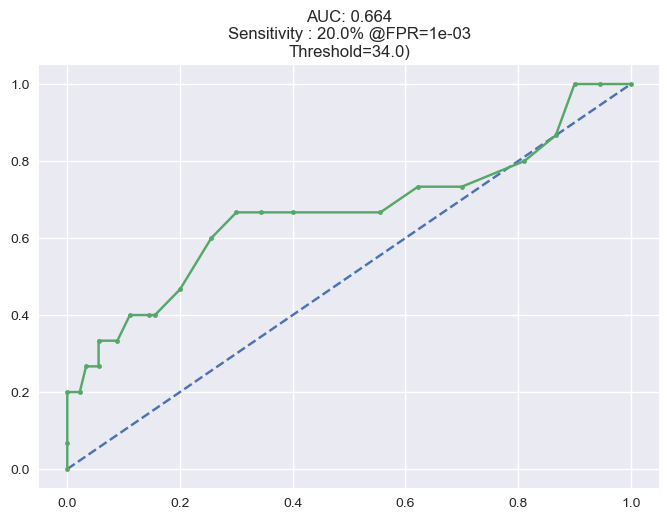

In [19]:
# ROC Curve for my own data for FPR=0 - Minutiae
result = Evaluator()
# Minutiae
result.evaluate(images, label, targetFPR = 1e-03)

For the CNN:  
First I create the architecture of the embedding model and compile it from the "CNN Build and train.ipynb". Simply run all the cells until the part where the siamese network is compiled and save the embedding model with the command  
embedding_model.save('untrained_model.h5'). Next I load the trained weights to this model. I can also run "evaluate()" on the untrained model before loading the weights first and compare the results with the model after I have loaded the trained weights.

1/1 [==============================] - 1s 1s/step


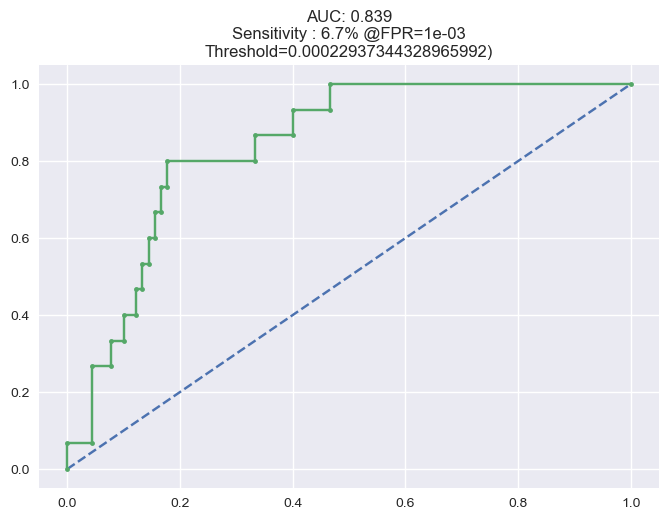

In [18]:
# ROC Curve for my own data for FPR=0 - CNN
result = Evaluator()

# CNN
embedding_model = tf.keras.models.load_model('untrained_model.h5') # Change to directory where you have it stored
embedding_model.load_weights('CustomCNN_final/emb_model.h5')       # Change to directory where you have it stored

# CNN requires 356x328 but I have 350x350 so I have to resize them first
# and binarize them again because after the resizing the will become grayscale.

X = np.empty((images.shape[0], 356, 328))
for i in range(images.shape[0]):
    temp = cv.resize(images[i,:,:], (328,356), interpolation = cv.INTER_CUBIC)
    nib_thr = threshold_niblack(temp, window_size=21, k=0.1)
    temp = temp > nib_thr
    temp = temp*255
    X[i,:,:] = temp
X = np.expand_dims(X, axis = -1)
Y = label

result.evaluate(X, Y, targetFPR = 1e-03, embedding_model = embedding_model)

## Evaluate on poly dataset - Minutiae and CNN

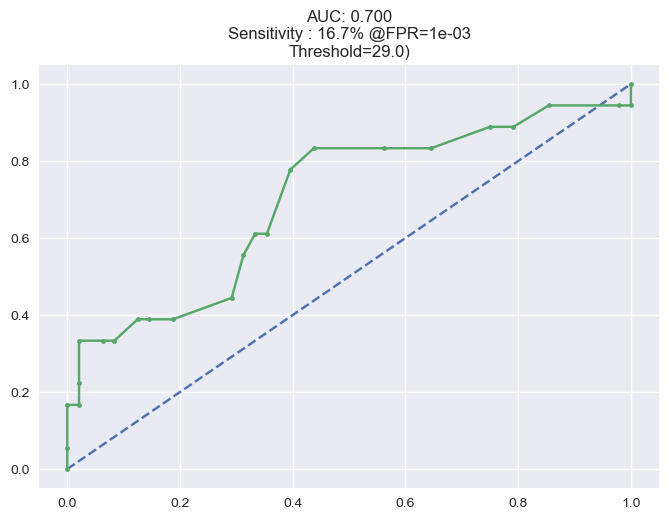

In [17]:
# ROC Curve for test data (fingers_poly_eval.npz) for FPR=0 - Minutiae
result = Evaluator()
# Minutiae
num=12
X = np.empty(shape = (num, 356, 328), dtype = 'float32')
Y = np.empty(shape = (num,), dtype = 'float32')
seq = [*range(160)]
ind = random.sample(seq, num//4)
for i in range(num//4):
    X[i*4, :, :] = x_eval[0, ind[i], :, :]
    X[i*4 + 1, :, :] = x_eval[3, ind[i], :, :]
    X[i*4 + 2, :, :] = x_eval[2, ind[i], :, :]
    X[i*4 + 3, :, :] = x_eval[5, ind[i], :, :]
    Y[i*4:(i+1)*4] = y_eval[0, ind[i]]
    
result.evaluate(X, Y, targetFPR = 1e-03)

For the CNN again:  
First I create the architecture of the embedding model and compile it from the "CNN Build and train.ipynb". Simply run all the cells until the part where the siamese network is compiled and save the embedding model with the command  
embedding_model.save('untrained_model.h5'). Next I load the trained weights to this model. I can also run "evaluate()" on the untrained model before loading the weights first and compare the results with the model after I have loaded the trained weights.

4/4 [==============================] - 7s 2s/step


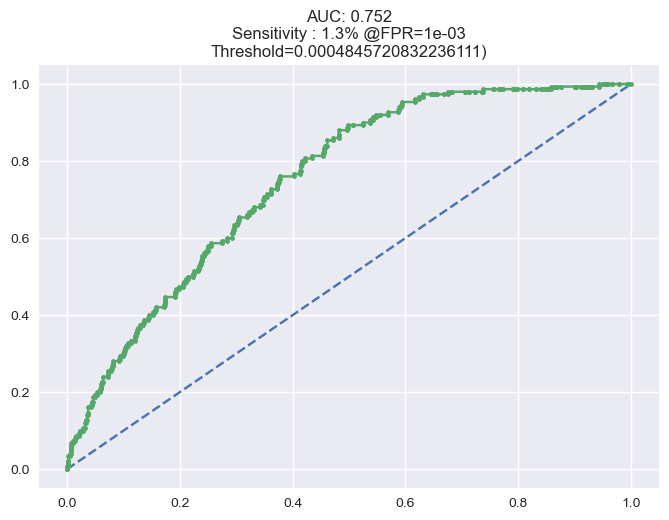

In [18]:
# ROC Curve for test data (fingers_poly_eval.npz) for FPR=0 - CNN
result = Evaluator()

# CNN
embedding_model = tf.keras.models.load_model('untrained_model.h5') # Change to directory where you have it stored
embedding_model.load_weights('CustomCNN_final/emb_model.h5')       # Change to directory where you have it stored
# 'CustomCNN_final/emb_model.h5' is the directory where my model weights are stored.
# Change it to your directory of choice.
num=100
X = np.empty(shape = (num, 356, 328), dtype = 'float32')
Y = np.empty(shape = (num,), dtype = 'float32')
seq = [*range(160)]
ind = random.sample(seq, num//4)
for i in range(num//4):
    X[i*4, :, :] = x_eval[0, ind[i], :, :]
    X[i*4 + 1, :, :] = x_eval[3, ind[i], :, :]
    X[i*4 + 2, :, :] = x_eval[2, ind[i], :, :]
    X[i*4 + 3, :, :] = x_eval[5, ind[i], :, :]
    Y[i*4:(i+1)*4] = y_eval[0, ind[i]]
    
result.evaluate(X, Y, targetFPR = 1e-03, embedding_model = embedding_model)

To simply compare 2 fingerprints and see if they are a match:  
- For minutiae run compare_fingerprints() and check the result and the threshold chosen
- For CNN do embedding_model.predict(x_i) for i=1,2 the 2 images, calculate their euclidean distance and compare to the chosen threshold.

## Display image processing

In [16]:
# Alignment and Cropping
img = cv.imread('./Fingerprint Data/myFingerprintData/new/L_p_2.jpg') # Change to directory where you have an image stored
aligner = OrientationCrop()
aligner.process_and_display(img)
#cropped = aligner.process(img) # To get the result and pass it to the next stage below

In [10]:
# Enhancment
enhancer = ProcessEnhance()
enhancer.process_and_display(cropped)